# LangChain 的 LLM 输出解析器  
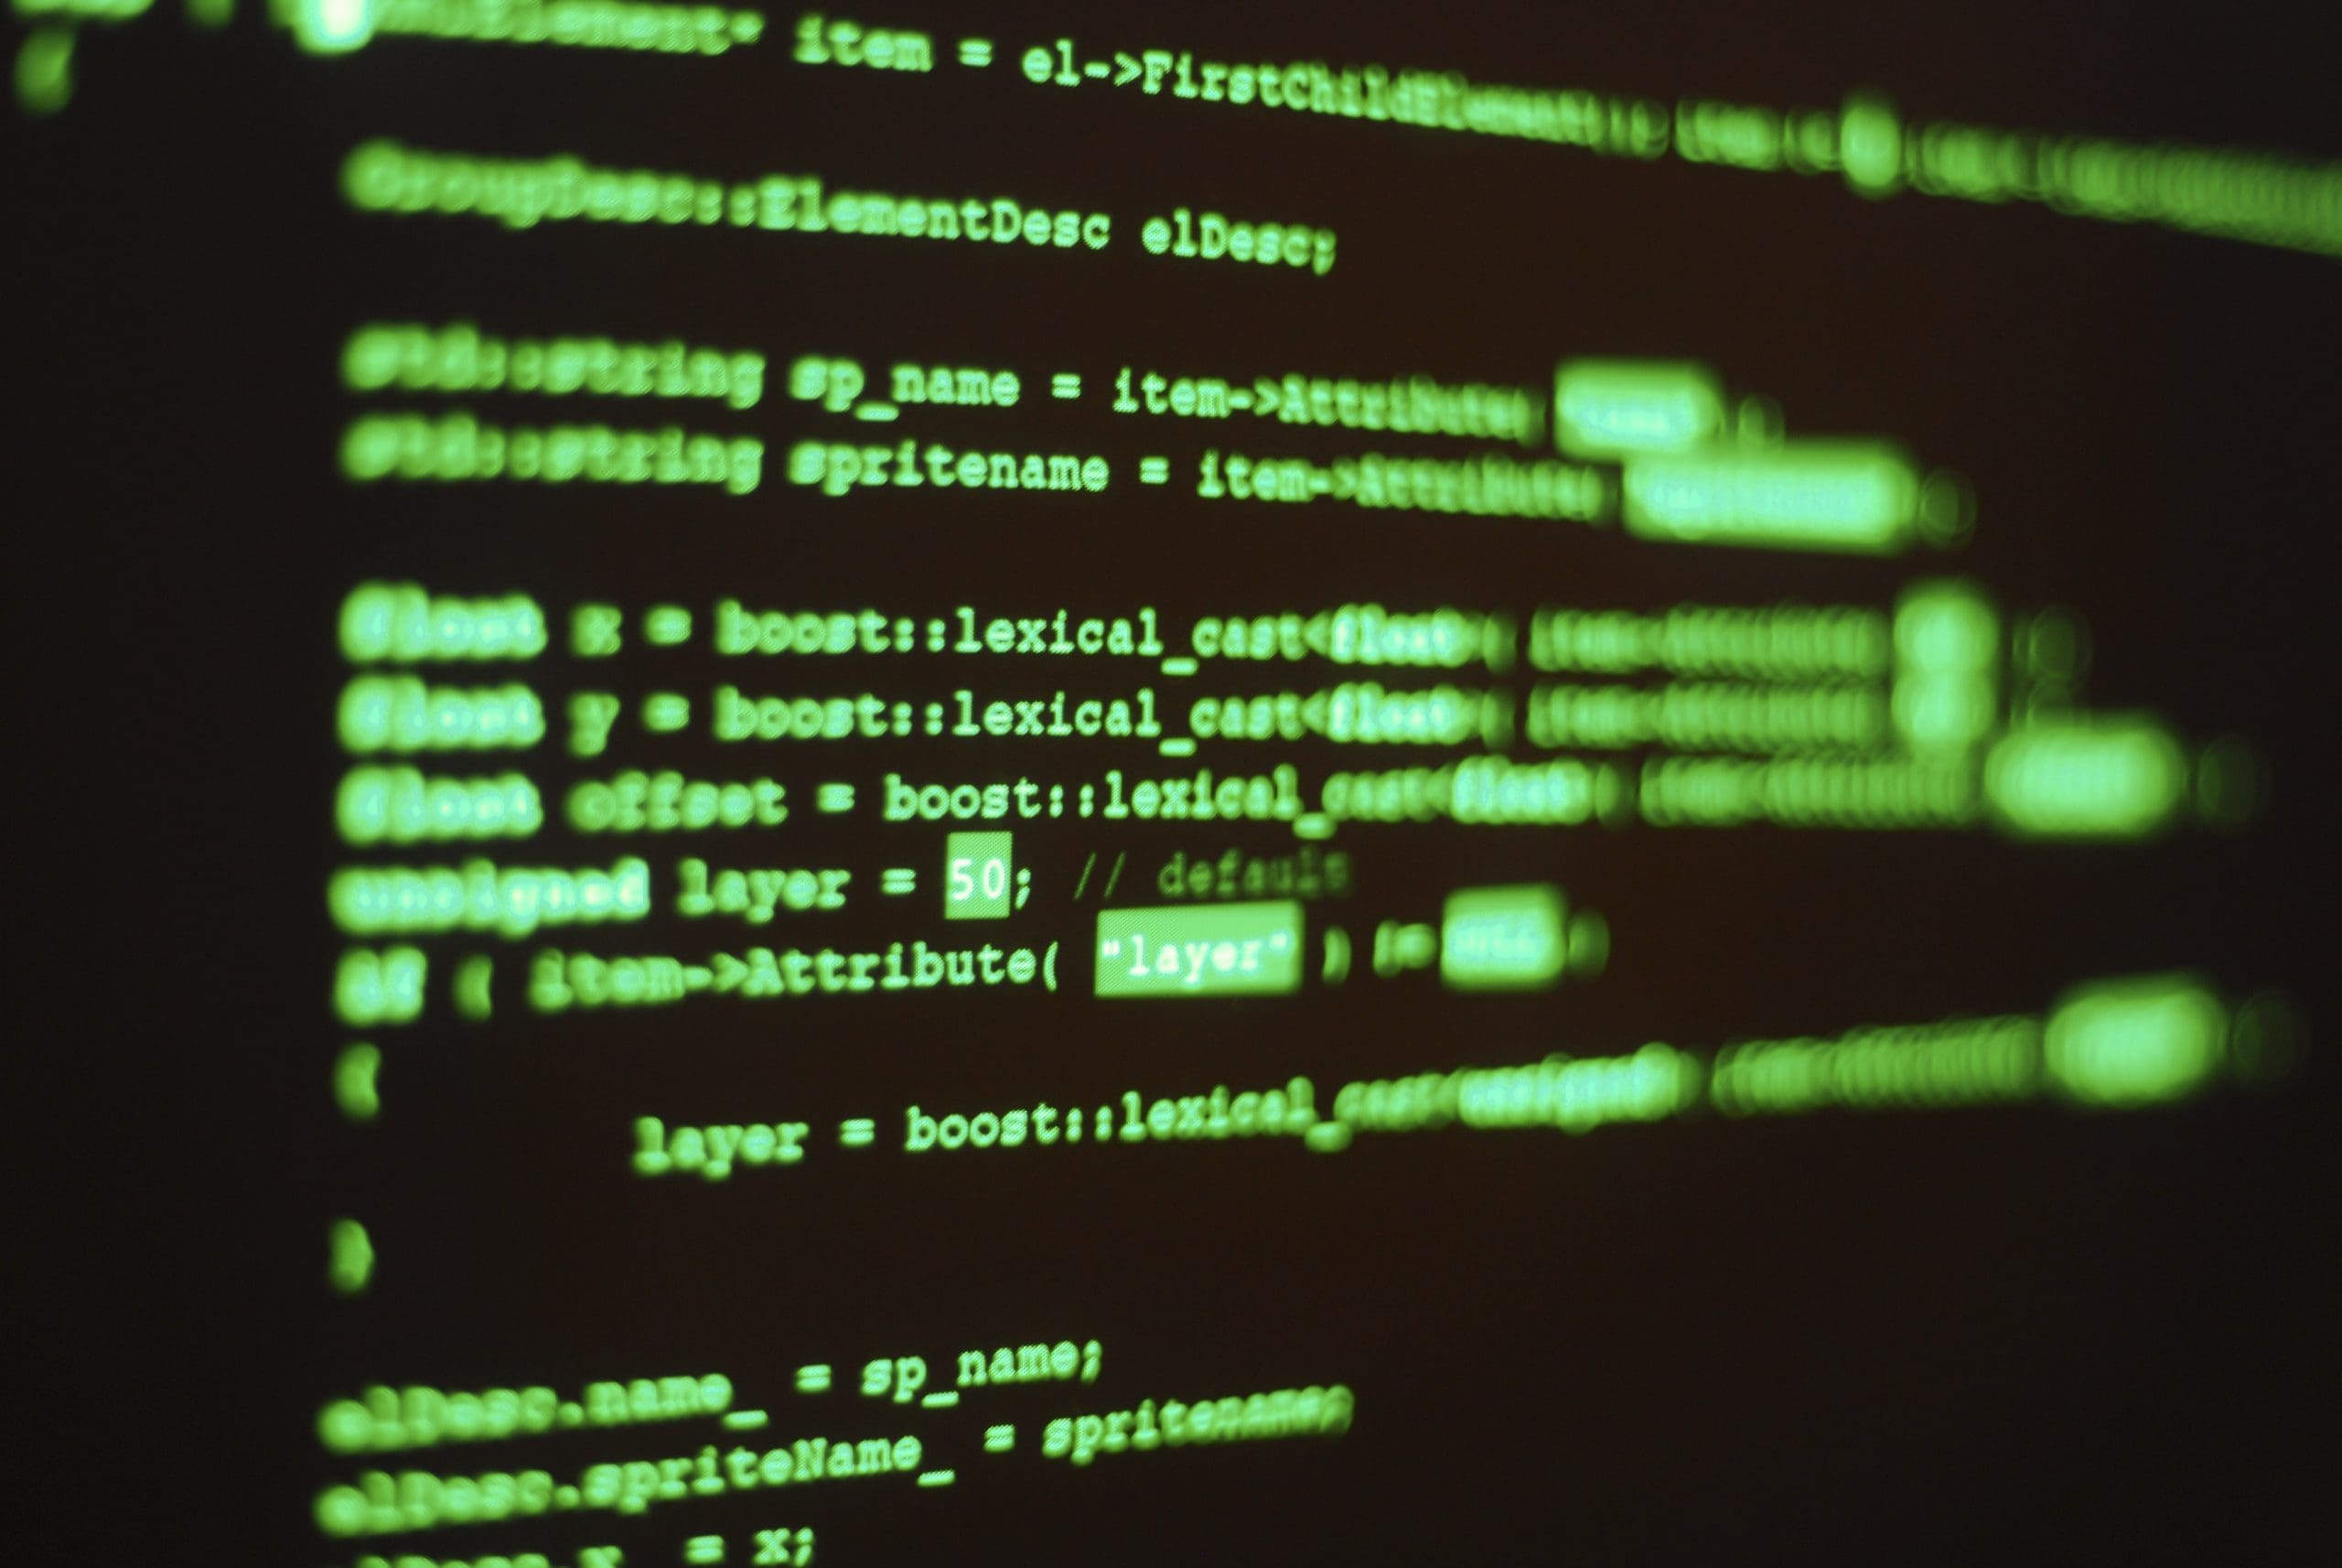
大型语言模型（LLM）彻底改变了人们的工作方式。通过帮助用户从文本提示中生成答案，LLM可以做很多事情，例如回答问题，总结，计划事件等等。  
然而，有时LLM的输出达不到我们的标准。例如，生成的文本可能完全错误，需要进一步指导。这就是 LLM 输出解析器的用武之地。  
通过使用 LangChain Output Parser 标准化输出结果，我们可以对输出进行一些控制。

## 准备工作
在本文中，我们将依赖 LangChain，因此我们需要在环境中安装它们。可以使用以下代码：
```python
pip install langchain langchain_core langchain_community langchain_openai python-dotenv
```

In [1]:
from langchain_openai import ChatOpenAI
# 使用一个openai风格的模型接口
model  = ChatOpenAI(base_url='https://open.bigmodel.cn/api/paas/v4/',
                  api_key='1111.11111111',
                  model='glm-4-flash',
                  temperature=0)

## 输出解析器 (Output Parser)
我们可以使用 LangChain 的许多类型的输出解析器来标准化 LLM 输出。为了更好地理解输出解析器，我们将尝试其中的几个。  
首先，我们将尝试 Pydantic Parser。它是一个输出解析器，我们可以用它来控制和验证生成文本的输出。

In [2]:
## Pydantic Parser示例1
from typing import List
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field,model_validator,field_validator

class MovieReview(BaseModel):
    title: str = Field(description="电影的标题或者名称")
    year: int = Field(description="电影的发行年份")
    genre: List[str] = Field(description="电影的类型标签")
    rating: float = Field(description="电影的评分1-10")
    summary: str = Field(description="电影情节的简要概述")
    review: str = Field(description="对这个电影进行点评")
    
    @field_validator('year')
    def valid_year(cls,val):
        if val >2025:
            raise ValueError("年份必须小于2025")
        return val
    @field_validator('rating')
    def valid_rating(cls,val):
        if val < 0 or val > 10:
            raise ValueError("评分必须是0到10分")
        return val
parser = PydanticOutputParser(pydantic_object=MovieReview)
prompt = PromptTemplate(
    template="使用中文。生成以下电影的影评:\n{movie_title}\n\n{format_instructions}",
    input_variables=["movie_title"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

movie_title = "匆匆那年"
review = chain.invoke({"movie_title": movie_title})
print(review)

title='匆匆那年' year=2014 genre=['爱情', '青春', '励志'] rating=8.5 summary='影片讲述了几个年轻人从高中到大学，再到步入社会，经历爱情、友情、梦想与现实的种种挑战，最终找到自己的方向和幸福的故事。' review='《匆匆那年》以其真挚的情感和对青春的细腻描绘，成功打动了无数观众的心。导演通过对人物关系的深入刻画，展现了青春期的迷茫与成长。影片中的音乐和画面都十分出色，为观众营造了一个充满回忆的氛围。虽然剧情略显平淡，但整体而言，这是一部值得一看的青春励志电影。'


In [3]:
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field, model_validator

# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

    # You can add custom validation logic easily with Pydantic.
    @model_validator(mode="before")
    @classmethod
    def question_ends_with_question_mark(cls, values: dict) -> dict:
        setup = values.get("setup")
        if setup and setup[-1] != "?":
            raise ValueError("Badly formed question!")
        return values


# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Joke)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# And a query intended to prompt a language model to populate the data structure.
prompt_and_model = prompt | model
output = prompt_and_model.invoke({"query": "Tell me a joke."})
parser.invoke(output)

Joke(setup="Why don't scientists trust atoms?", punchline='Because they make up everything!')

示例1 创建了一个名为 MovieReview 的类，它包含我们想要的所有信息输出。输出将提供标题、年份、流派、评级、摘要和评论的输出。在每个输出中，我们定义我们想要的输出的描述。 
从输出中，我们为年份和评分创建了一个验证器，以确保结果不是我们想要的。如果需要，您还可以添加更多的验证机制。  
然后我们创建提示模板，它将接受我们的查询输入及其格式。
我们要做的最后一件事是创建模型链并传递查询以获得结果。注意，上面的 chain 变量接受使用 "|" 这是LangChain中的一种独特方法。
Output:

title='匆匆那年' year=2014 genre=['爱情', '青春', '励志'] rating=8.5 summary='影片讲述了几个年轻人从高中到大学，再到步入社会，经历爱情、友情、梦想与现实的种种挑战，最终找到自己的方向和幸福的故事。' review='《匆匆那年》以其真挚的情感和对青春的细腻描绘，成功打动了无数观众的心。导演通过对人物关系的深入刻画，展现了青春期的迷茫与成长。影片中的音乐和画面都十分出色，为观众营造了一个充满回忆的氛围。虽然剧情略显平淡，但整体而言，这是一部值得一看的青春励志电影。'


正如您所看到的，输出遵循我们想要的格式，并且结果通过了我们的验证方法。  
Pedantic 解析器是我们可以使用的标准输出解析器。如果我们已经有了一个特定的格式，我们可以使用其他的输出解析器。例如，如果我们只想在逗号分隔的项目中得到结果，可以使用CSV解析器。

In [4]:
from langchain.output_parsers import CommaSeparatedListOutputParser

output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()

prompt = PromptTemplate(
    template="List six {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions},
)

from langchain_core.prompts import PromptTemplate

chain = prompt | model | output_parser

print(chain.invoke({"subject": "Programming Language"}))

['Python', 'JavaScript', 'Java', 'C++', 'Ruby', 'PHP']


Output:  
['Java', 'Python', 'C++', 'JavaScript', 'Ruby', 'Swift']

结果是一个列表，其中的值由逗号分隔。如果结果是以逗号分隔的，您可以按照自己喜欢的方式扩展模板。  
也可以获取日期时间格式的输出。通过更改代码和提示符，我们可以预期我们想要的结果。  

In [26]:
from langchain.output_parsers import DatetimeOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

output_parser = DatetimeOutputParser()

format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="""Answer the users question:

    {question}

    {format_instructions}""",
    input_variables=["question"],
    partial_variables={"format_instructions": format_instructions},
)

chain = prompt | model | output_parser

print(chain.invoke({"question": "When is the Python Programming Language invented?"}))

1989-12-20 23:59:59.999999


Output:
1991-02-20 00:00:00

可以看到结果是日期时间格式的。 
这就是LangChain LLM输出解析器的全部内容。你可以访问他们的文档来找到你需要的输出解析器，或者使用Pydantic自己构建它。 

### json 输出解析器

In [5]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

# And a query intented to prompt a language model to populate the data structure.
joke_query = "Tell me a joke."

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Joke)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser

chain.invoke({"query": joke_query})

{'setup': "Why don't scientists trust atoms?",
 'punchline': 'Because they make up everything!'}

In [6]:
# 不基于 pandantic
joke_query = "Tell me a joke."

parser = JsonOutputParser()

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser

chain.invoke({"query": joke_query})

{'joke': "Why don't scientists trust atoms? Because they make up everything!"}

### 结论   
在本文中，我们学习了LangChain输出解析器，它对LLM生成的文本进行解析。我们可以使用Pydantic Parser来构造LLM输出并提供您想要的结果。LangChain还有许多其他输出解析器可以适合您的情况，例如CSV解析器和日期时间解析器。

### 参考资料  
1. https://machinelearningmastery.com/understanding-langchain-llm-output-parser/?ref=dailydev
2. https://python.langchain.com/docs/concepts/output_parsers/
3. https://python.langchain.com/docs/how_to/output_parser_json/